# Handwritten Number Recognization

## Group Information
Team Name:
<br>Participants:

## 0. Project Information
We have already creat the training dataset in *CreateTrainSet* . In this module, we will used the training dataset to recognize the handwritten digits.  
We are going to complete the following steps:
* Import the image with handwritten digits or take a photo of the handwritten digits to be detected.
* Preprocess the image, including but not limited to converting the picture into a grayscale image, and then into a binary image. 
* Segmenting the picture to extract a single digit.
* Recognize the handwritten digits based on kNN algorithm with the functions supplied by OpenCV.
* Display the detected digits with digital tube.

## 1. Initialize the Environment
As usual, let's first initialize the environment. This step includes importing modules, getting project and file paths.

In [1]:
%load_ext autoreload
%autoreload 1
# number detected related
import cv2
import os
import numpy as np
import math
from lib import imshow
import random
from PIL import Image, ImageEnhance

# get the project path
PRJ_PATH = os.getcwd()
# OPENCV_data.npz
TRAIN_DATA_NAME = "OPENCV_data.npz"

We will complete some independent functions in *my_function*.   
Here let's first import the function we are going to work on.

In [2]:
%aimport my_function
from my_function import image_split_row, image_split_column, led_display, take_photo
img_path=take_photo()
print(img_path)

/UserData/2023-11-22T08:27:37.970926


## 2. Import the Training Dataset
In this module let's first import the training dataset which we generate in *CreateTrainSet* . Then let's create a kNN object and train it.

In [3]:
# load the knn training data
with np.load(PRJ_PATH + '/TrainingData/' + TRAIN_DATA_NAME) as data:
    train = data["train"]
    train_labels = data["train_labels"]
train = train.astype(np.float32)
train_labels = train_labels.astype(np.float32)

# create KNN obj
knn = cv2.ml.KNearest_create()
knn.train(train,cv2.ml.ROW_SAMPLE,train_labels)

True

## 3. Image Preprocessing
Before we start digits recognition, we need to do some preprocessing on the image. The preprocess includes the change of the image color gamut and the space domain. Let's start!

### Import Pending Pictures
- In first stage, we will use existing pictures with handwritten digits. Import the image with `dst = cv2.imread(filename)` and show the image with `imshow(src)`.  
<br>
- In late stage, we will use the camera to take pictures. In this stage, you first need to build the camera control circuit on the breadboard. Then finish the function of taking pictures in `take_photo()` of *my_function*.

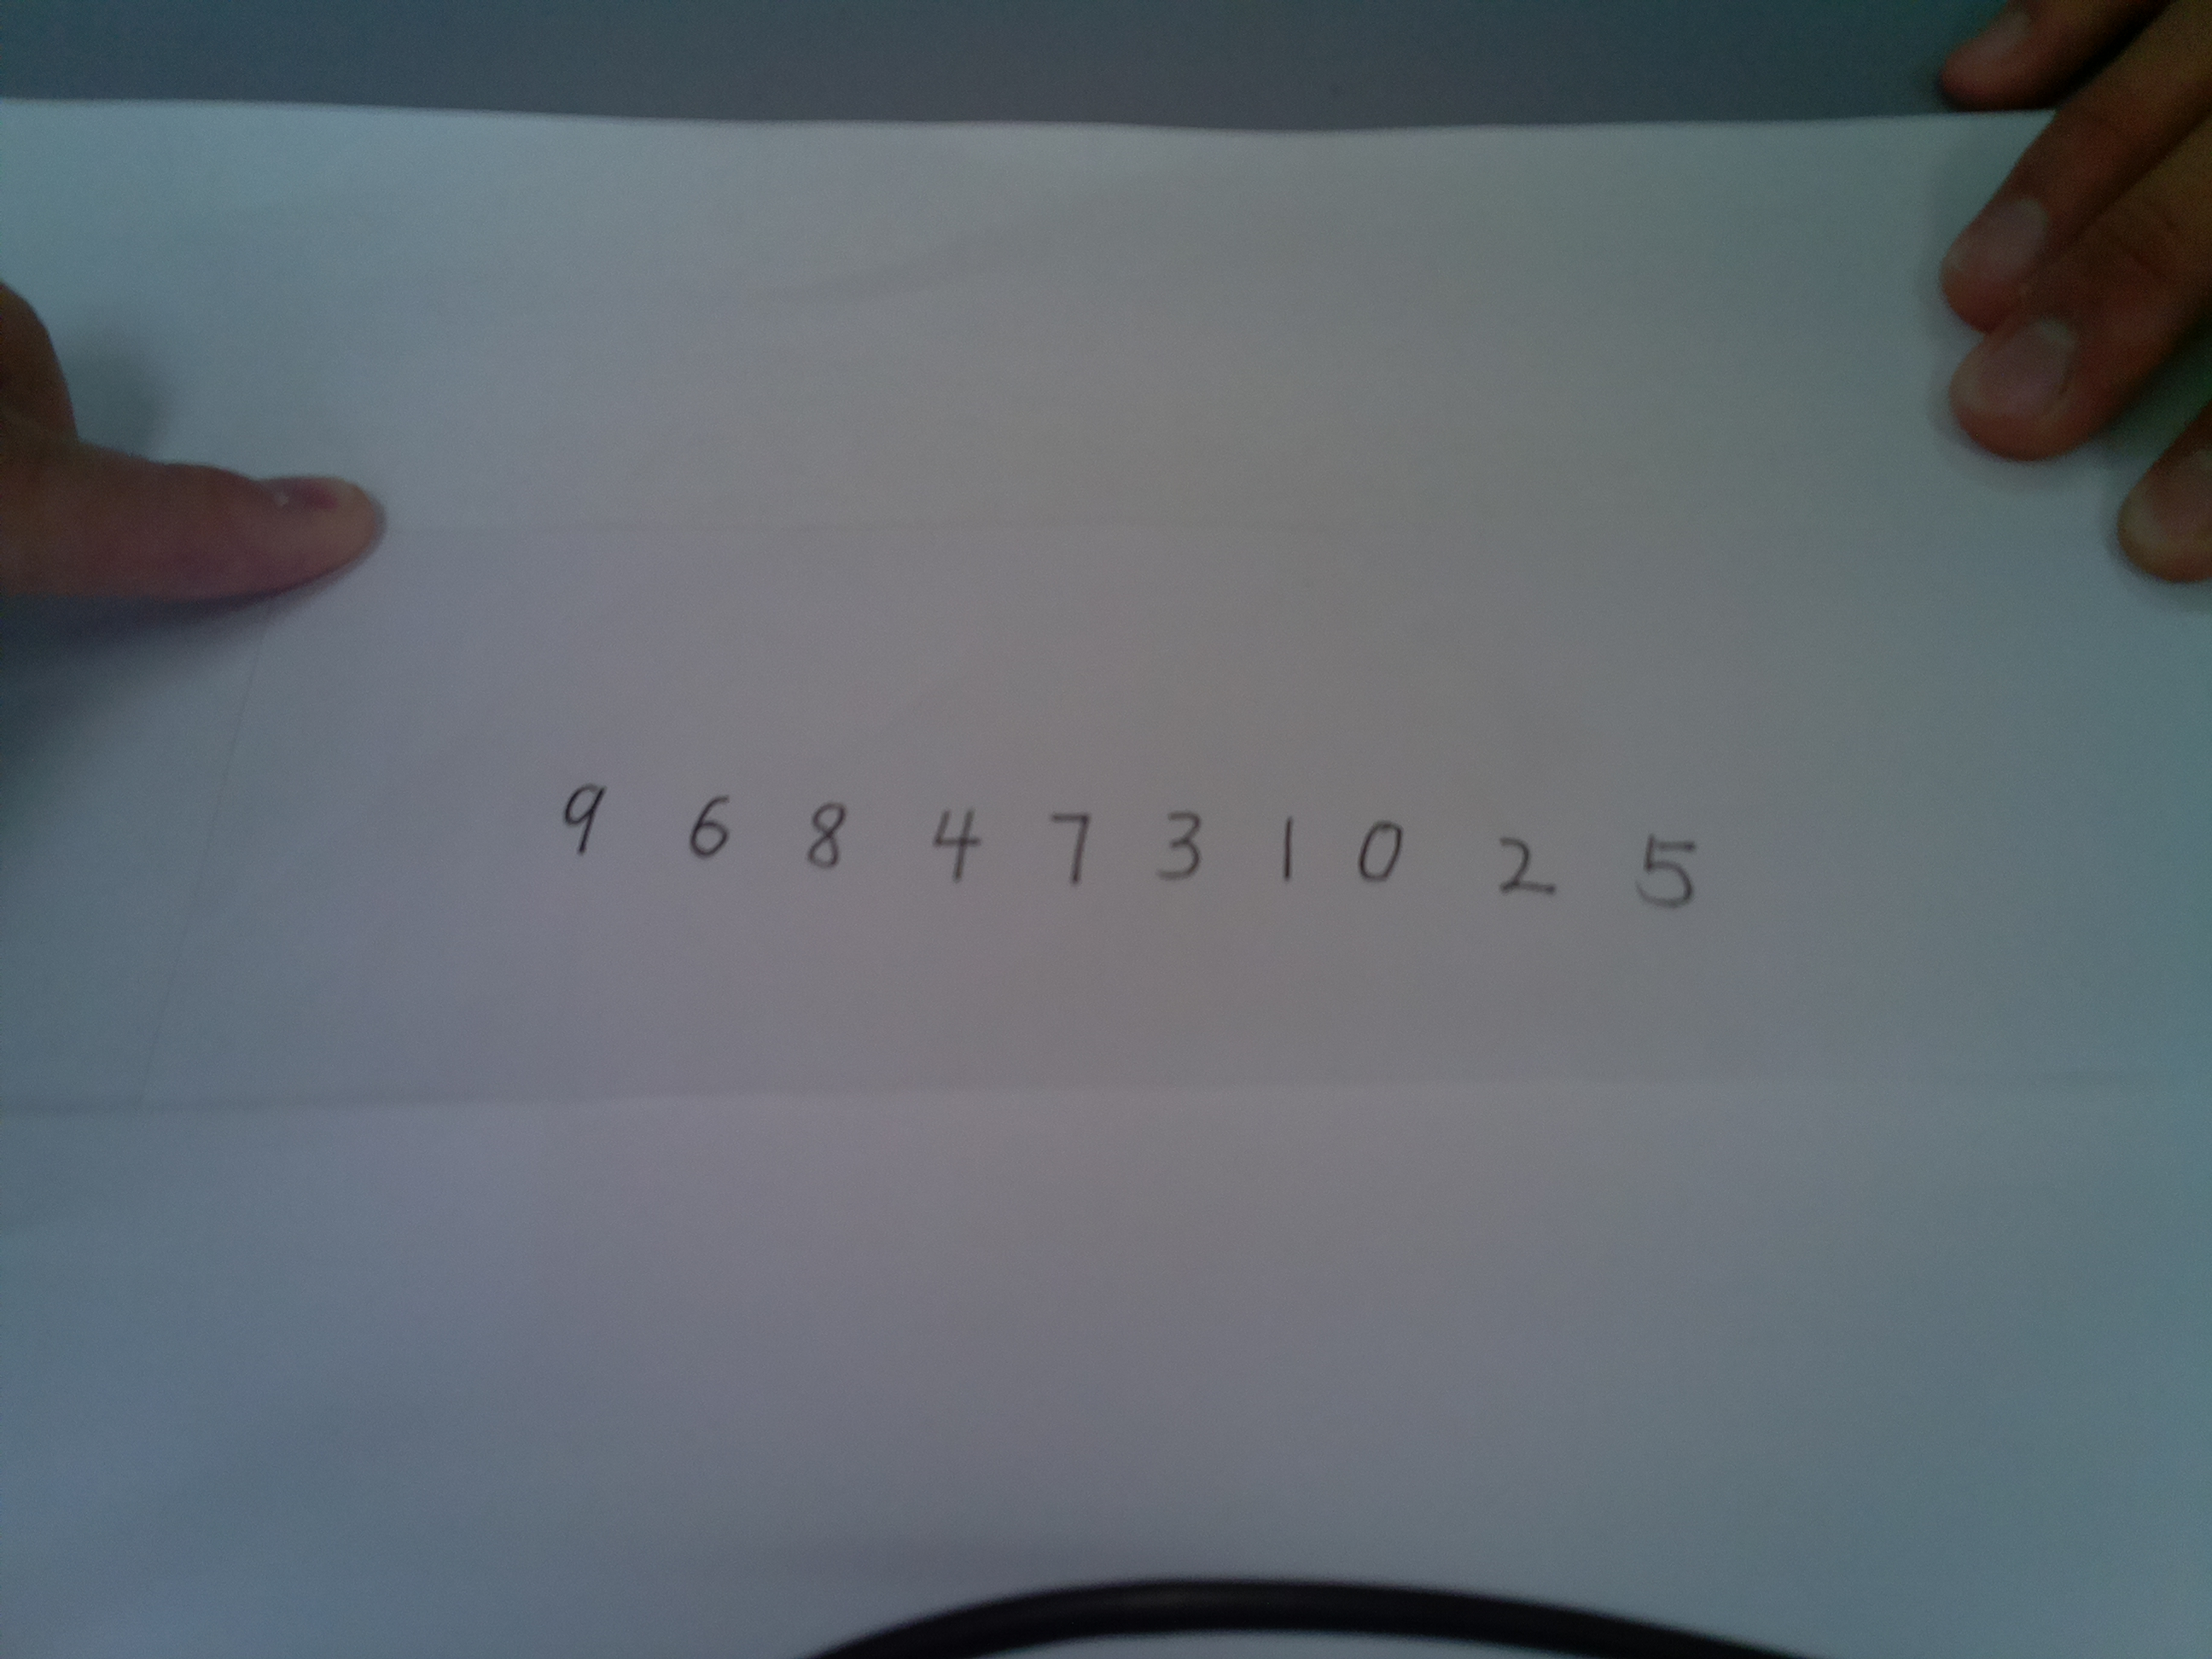

In [4]:
image = PRJ_PATH + img_path +".jpg"
#image = PRJ_PATH + "/UserData/test3_2.jpg"
img = cv2.imread(image)
imshow(img)

### Get the Grayscale Image
After we get the image, we should first convert the color image into a grayscale image.
<br>
Do it with `dst = cv2.cvtColor(src,code)`.

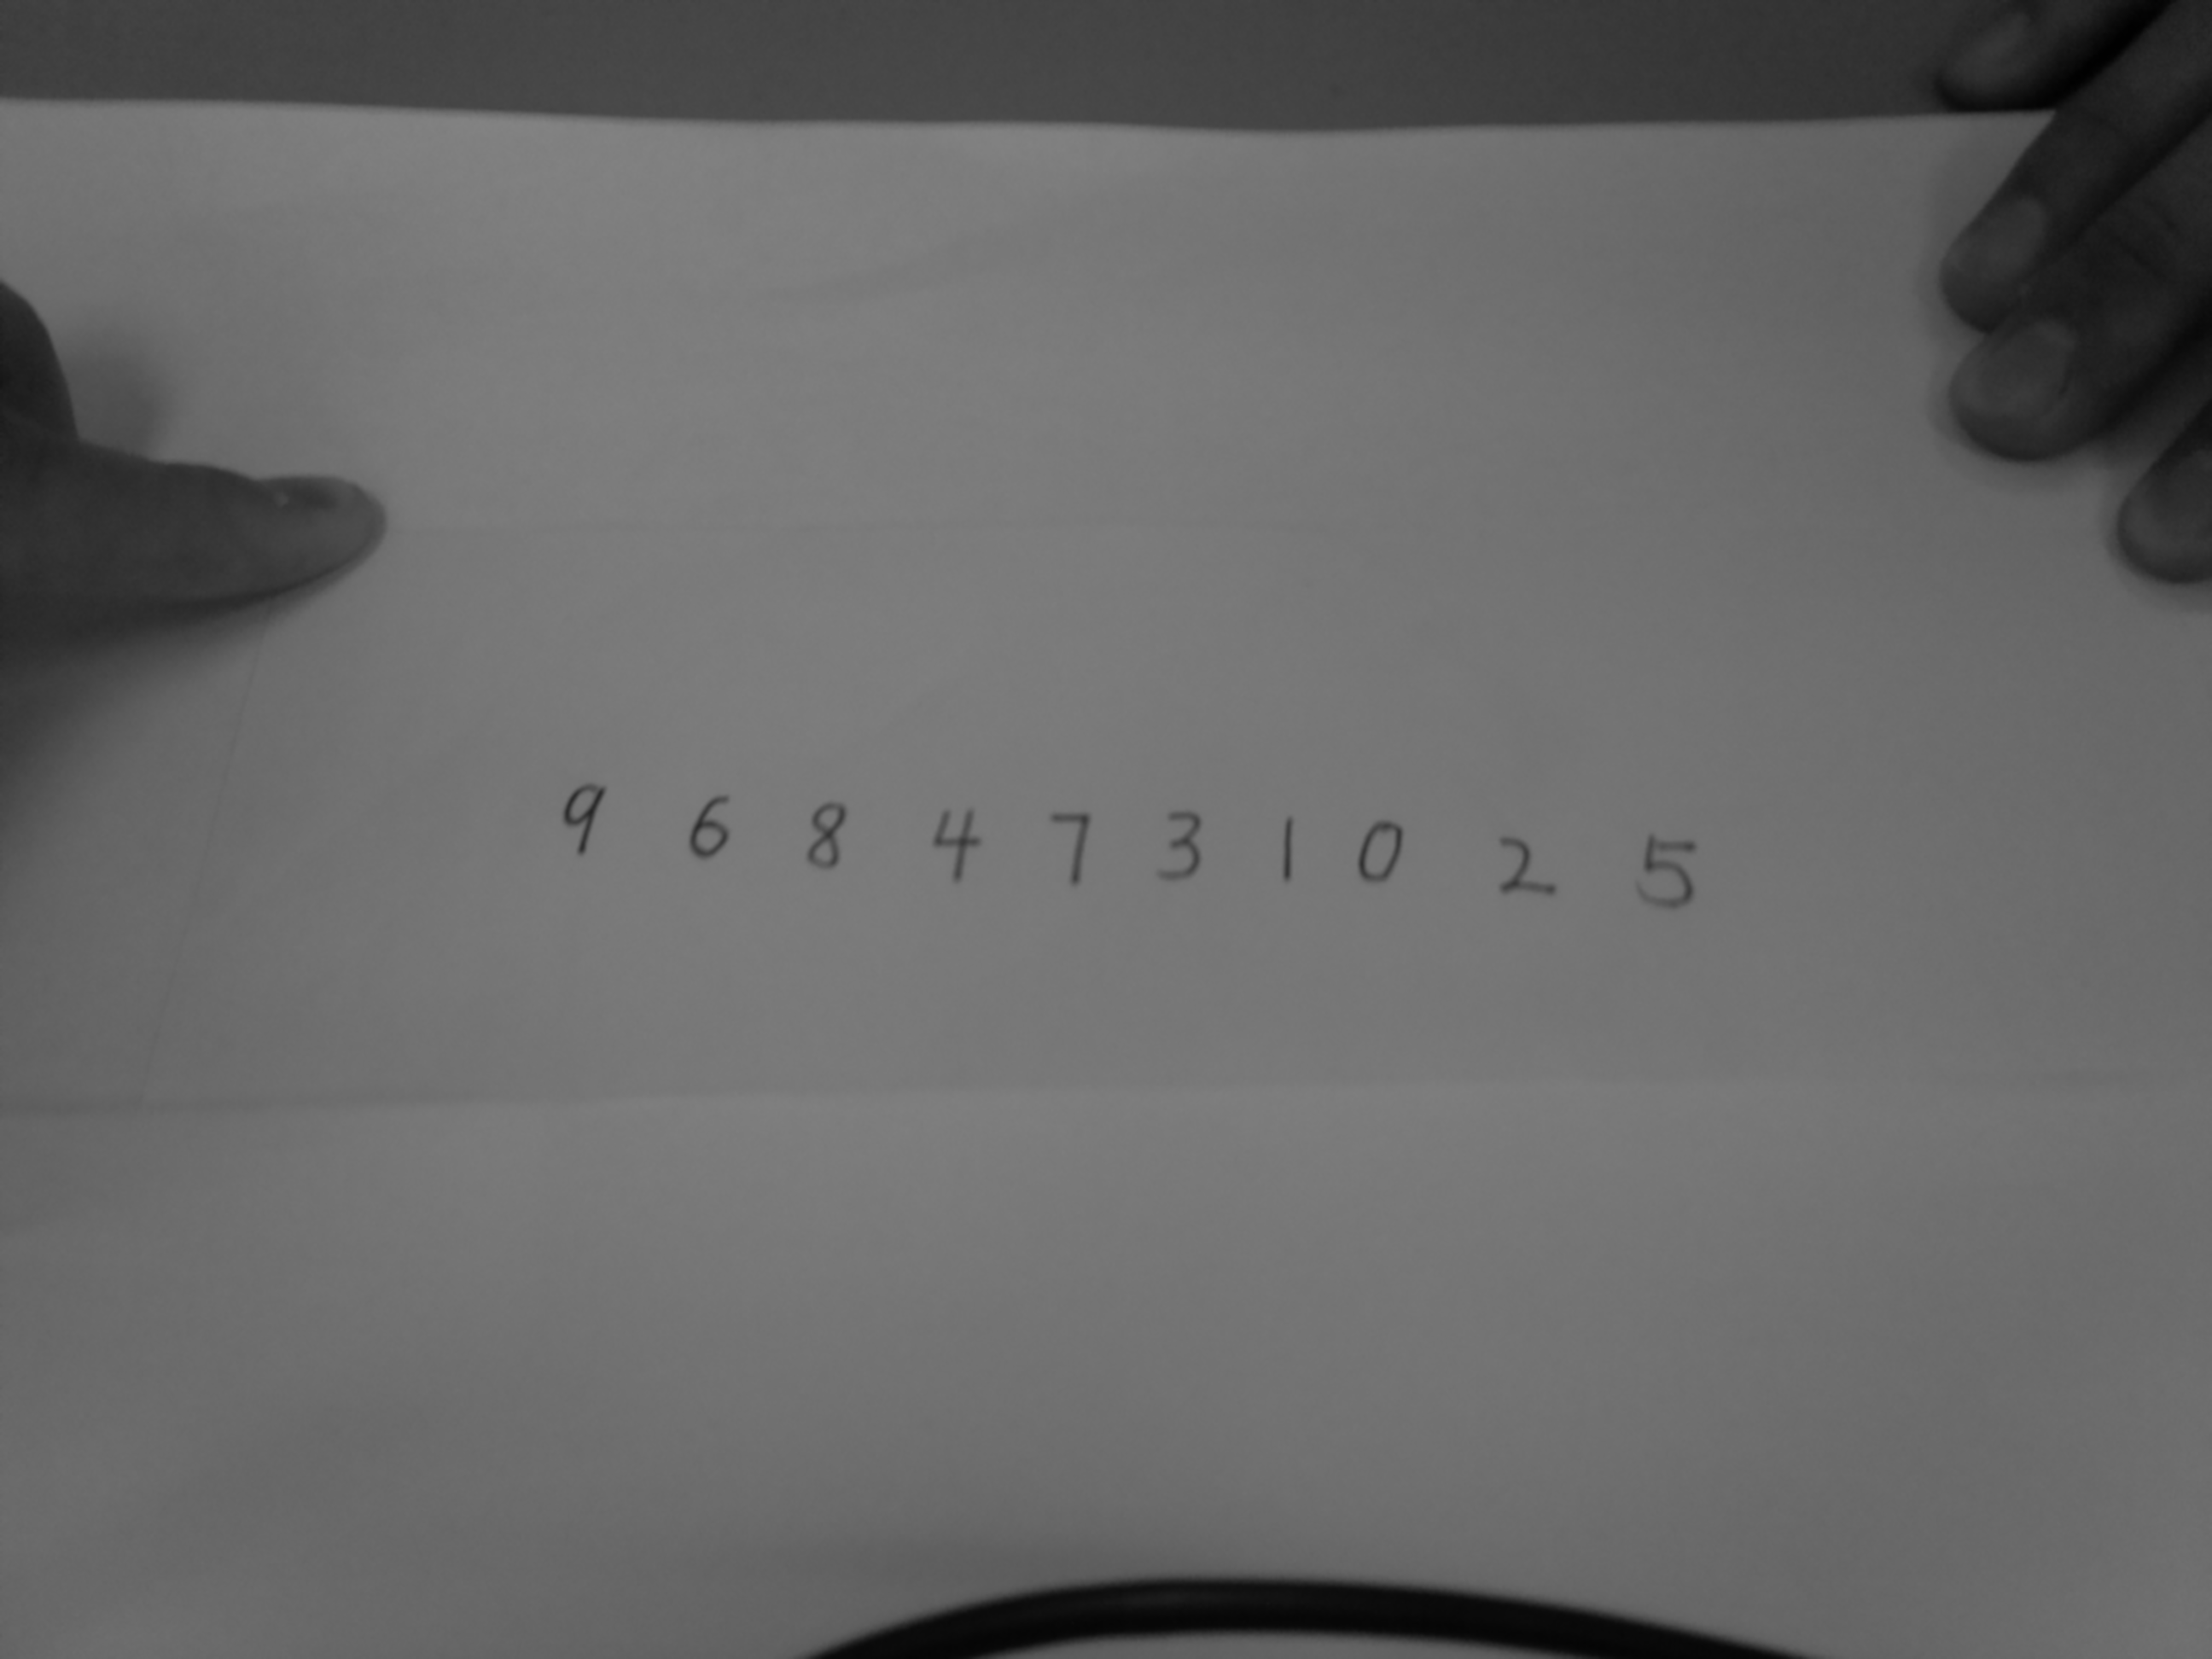

In [5]:
Gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
imgGray = cv2.GaussianBlur(Gray, (7, 7), 0)
imshow(imgGray)

### Get the Binary Image
After getting the grayscale image, we need to further convert the grayscale image into a binary image.
<br>
Do it with `dst=cv2.threshold(src, thresh, maxval, type)`.
<br>**src**: Image to be converted.
<br>**thresh**: Threshold value.
<br>**maxval**: Maximum value to use with `cv2.THRESH_BINARY` or `cv2.THRESH_BINARY_INV`.
<br>**type**: Thresholding type. It can be `cv2.THRESH_BINARY`, `cv2.THRESH_BINARY_INV`, `cv2.THRESH_TRUNC`, `cv2.THRESH_TOZERO`, `cv2.THRESH_TOZERO_INV`.

<br>
Note: try to adjust parameter `thresh` to get a binary image without extra points or noise.

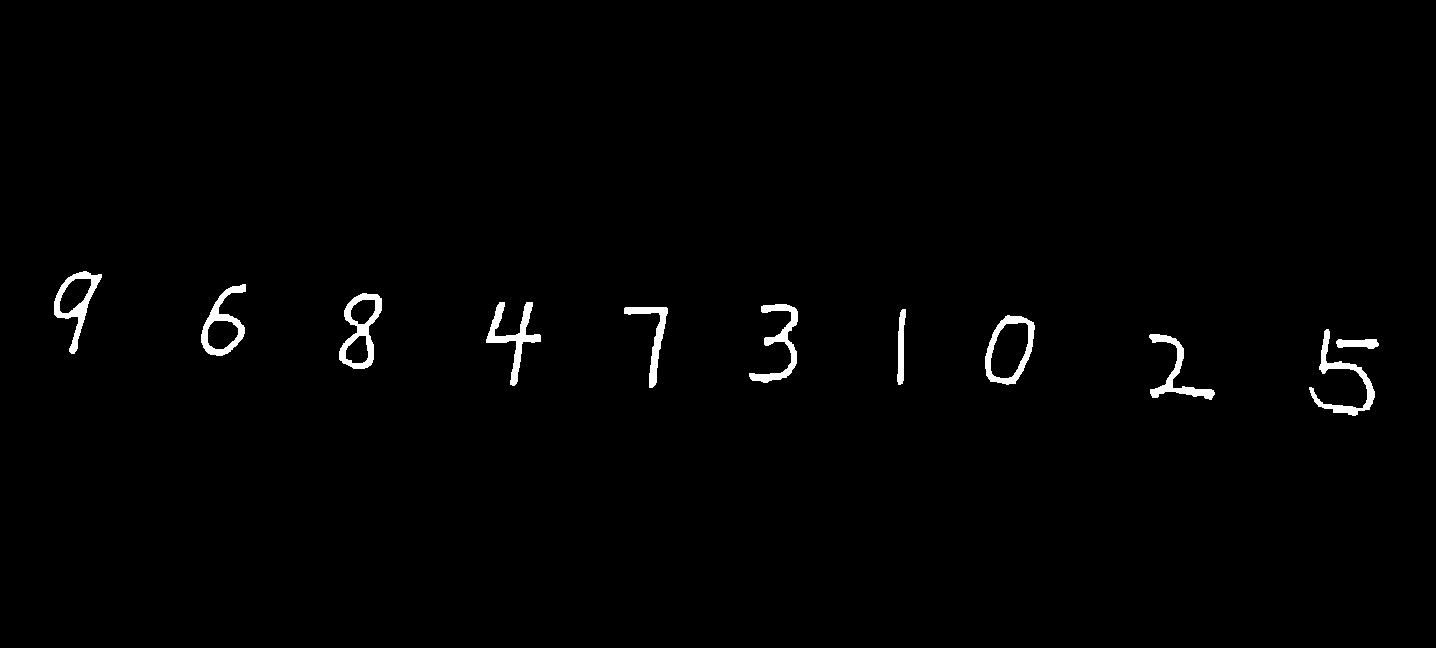

In [7]:
imgBin1 = cv2.adaptiveThreshold(imgGray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 13, 2)
h,w = imgBin1.shape
imgBin1 = imgBin1[h//3 : 2*h//3 , w//4-40 : 3*w//4+100]
kernel = np.ones((3, 3), np.uint8)
imgBin2 = cv2.morphologyEx(imgBin1,cv2.MORPH_OPEN,kernel)
kernel = np.ones((7, 7), np.uint8)
imgBin = cv2.morphologyEx(imgBin2, cv2.MORPH_CLOSE,kernel)
imshow(imgBin)

##### Split the Image

When we start to recognize handwritten digits, we should find out the corresponding digits one by one. So we need to segment the binary image to obtain a single digit.

Remeber how we split the image in *CreatTrainSet*? Since the numbers in *digits.png* have the same size (20x20) and are arranged neatly, we can simply divide *digits.png*  according to the size of the numbers. 
But this time, the numbers to be detected are not restricted to strict positions, and their size may also be different, which means we can no longer use `np.hsplit()` and `np.vsplit()` for segmentation.

However in the previous steps, we have already get the binary image which only contains 0 and 255. In our project, 0 represents black, which is the background of the image. And 255 represents white, which constitutes the number on the picture. Therefor, we can determine the boundary of the handwritten number through the transformation of 0 and 255.

Head to [my_function.py](/edit/ProjectExercise/my_function.py) to complete function `image_split_row` and `image_split_column`. 

- In the first stage, we will use the picture with only one line of numbers. Just run the following cell to view the split image.
- In the later stage, we will use the picture with multiple lines of numbers. Adjust the code in the cell below, and then run it to see the splitted image.

0:


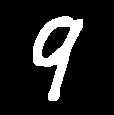

1:


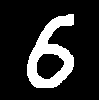

2:


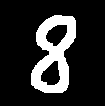

3:


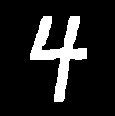

4:


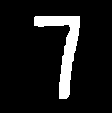

5:


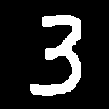

6:


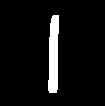

7:


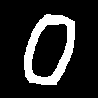

8:


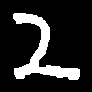

9:


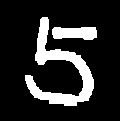

In [8]:
imgRow = image_split_row(imgBin)
imgMonos = []
for row in range(len(imgRow)):
    imgCol = image_split_column(imgRow[row])
    rowmono = []
    for col in range(0,len(imgCol)):
        imgMono = image_split_row(imgCol[col])
        h, w = imgMono[0].shape
        if h<=10 and w<=10:
            continue
        imgMono[0] = np.pad(imgMono[0], pad_width = max(h,w)//5, mode='constant', constant_values=0)
        h,w = imgMono[0].shape
        if h>w:
            bb = (h-w)//2
            imgMono[0] = np.pad(imgMono[0], ((0,0), (bb,bb)), mode='constant', constant_values=0)
        else:
            bb = (w-h)//2
            imgMono[0] = np.pad(imgMono[0], ((bb,bb), (0,0)), mode='constant', constant_values=0)
        print(f"{(col)}:")
        kernel = np.ones((max(h,w)//25, max(h,w)//25), dtype=np.uint8)
        imgMono[0] = cv2.dilate(imgMono[0], kernel, 7)
        imshow(imgMono[0])
        rowmono.append(imgMono[0])
    imgMonos.append(rowmono)

We need to resize them to a uniform shape. 
Also we should reshape the image to make it consistent with the kNN lib. 
Fill in the two variables

In [9]:
resizeSize = (20 , 20)
reShapeSize = (1, 400)

## 4. Recognize the Handwritten Number
Let's complete the resize and reshape operations of the image, and do the recognization.
- In the first stage, we only have one line of numbers. Run the following cell to get the recognized numbers.
- In the later stage, we will deal with multipul lines of numbers. Adjust the cell below to display the multiple rows of numbers.

In [10]:
# resize and reshape the image with single number
# then recognize the number with knn.findNearest(imgReshape,k=?)
numberList = [[]for i in range(len(imgRow))]
for i in range(0,len(imgRow)):
    for j in range(0,len(imgMonos[i])):
        imgResize = cv2.resize(imgMonos[i][j], resizeSize)
        imshow(imgResize)
        imgReshape = imgResize.reshape(reShapeSize).astype(np.float32)
        _,result,_,_ = knn.findNearest(imgReshape,k=7)
        numberList[i].append(int(result))
    
for i in range(0,len(imgRow)):
    if len(numberList[i])==0:
        continue
    print("The "+str(i+1)+"th row has:" + str(numberList[i]))

The 1th row has:[9, 5, 8, 4, 3, 3, 1, 0, 2, 5]


## 5. Display the Number by Digital Tube
Next we will use a digital tube to display the numbers we finally recognize.

We will use a common anode digital tube to display the result. Please complete the following operations:
1. Use breadboard, DuPont cables and GPIO pins of Raspberry Pi to complete the circuit for digital tube.
2. Complete the relevant code for digital tube in function `led_display` of *my_function.py*.

About the cell below:
- In the first stage with only one line of numbers,run the cell below to display the result.
- In the later stage with multiple lines of numbers, adjust the code in the cell to display the total results.

In [12]:
# do the image splite and reshape
# then recognize the number with knn.findNearest(imgReshape,k=?)
for i in range(0,len(imgRow)):
    if len(numberList[i])==0:
        continue
    led_display(numberList[i])

# Congratulate!
## You have completed all the tasks.